Models found: ['y_pred_rf', 'y_pred_xgb', 'y_pred_gb', 'y_pred']


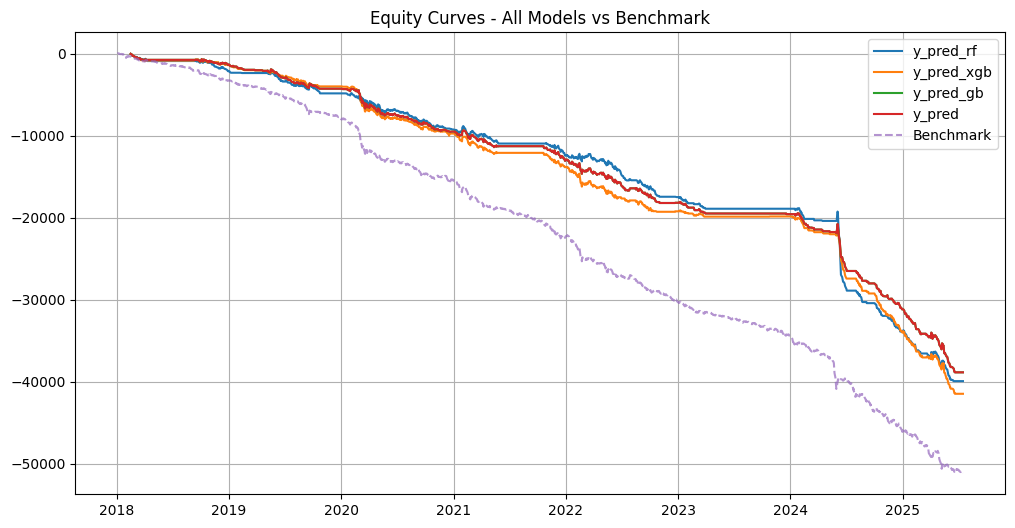


=== Strategy Metrics ===
     Model     Total PnL    Sharpe        Max DD  Trades  Win Rate
 y_pred_rf -39938.566842 -3.207265 -11704.224184     914  0.288840
 y_pred_gb -38866.329238 -3.527154           NaN     914  0.291028
    y_pred -38866.329238 -3.527154           NaN     914  0.291028
y_pred_xgb -41484.487595 -3.661224           NaN     914  0.292123


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Config ---
PICKLE_PATH = Path("data/processed/underlying_price_with_preds.pkl")
FWD_TARGET = "hv10_fwd"
HOLD_DAYS = 1
THRESHOLD_METHOD = "median"
TRANSACTION_COST = 0.0
SCALE = 1.0
DT = 1 / 252

# --- Load data ---
if PICKLE_PATH.exists():
    df = pd.read_pickle(PICKLE_PATH)
else:
    raise FileNotFoundError(f"{PICKLE_PATH} not found.")

# --- Models to evaluate ---
pred_cols = [c for c in df.columns if c.startswith("y_pred")]
print("Models found:", pred_cols)

# --- Helper functions ---
def annualized_sharpe(returns, periods_per_year=252):
    mean = returns.mean()
    std = returns.std(ddof=0)
    return (mean / std) * np.sqrt(periods_per_year) if std != 0 else np.nan

def max_drawdown(cum_series):
    running_max = cum_series.cummax()
    drawdown = (cum_series - running_max) / running_max.replace(0, np.nan)
    return drawdown.min()

# --- Benchmark PnL calc ---
df["spot"] = df["Close"].astype(float)
df["spot_next"] = df["spot"].shift(-HOLD_DAYS)
df["abs_move"] = (df["spot_next"] - df["spot"]).abs()
df["benchmark_cost"] = df[FWD_TARGET] * df["spot"] * np.sqrt(DT)
df["benchmark_pnl"] = df["abs_move"] - df["benchmark_cost"]
df["benchmark_cum"] = df["benchmark_pnl"].cumsum()

metrics_list = []

# --- Loop over each model ---
plt.figure(figsize=(12, 6))
for col in pred_cols:
    df_model = df.dropna(subset=["Close", col, "spot_next"]).copy()
    
    # Threshold
    if THRESHOLD_METHOD == "median":
        threshold = df_model[col].median()
    elif THRESHOLD_METHOD == "quantile":
        threshold = df_model[col].quantile(0.6)
    else:
        threshold = float(THRESHOLD_METHOD)

    df_model["signal"] = (df_model[col] > threshold).astype(int)
    df_model["cost"] = SCALE * df_model[col] * df_model["spot"] * np.sqrt(DT)
    df_model["raw_pnl"] = df_model["abs_move"] - df_model["cost"]
    df_model["tc"] = TRANSACTION_COST * df_model["spot"] * 2.0
    df_model["pnl_signal"] = (df_model["raw_pnl"] - df_model["tc"]) * df_model["signal"]
    df_model["cum_pnl_signal"] = df_model["pnl_signal"].cumsum()

    metrics_list.append({
        "Model": col,
        "Total PnL": df_model["pnl_signal"].sum(),
        "Sharpe": annualized_sharpe(df_model["pnl_signal"]),
        "Max DD": max_drawdown(df_model["cum_pnl_signal"]),
        "Trades": int(df_model["signal"].sum()),
        "Win Rate": (df_model.loc[df_model["signal"] == 1, "pnl_signal"] > 0).mean()
    })

    plt.plot(df_model.index, df_model["cum_pnl_signal"], label=col)

# --- Plot benchmark ---
plt.plot(df.index, df["benchmark_cum"], label="Benchmark", linestyle="--", alpha=0.7)
plt.title("Equity Curves - All Models vs Benchmark")
plt.legend()
plt.grid(True)
plt.show()

# --- Metrics table ---
metrics_df = pd.DataFrame(metrics_list)
print("\n=== Strategy Metrics ===")
print(metrics_df.sort_values(by="Sharpe", ascending=False).to_string(index=False))
